In [1]:
import os
import shutil
import torch
import torch.nn.functional as F
import random
from torch import nn
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
with open('./data/alphabet.txt') as f:
    alphabet = f.readline()
print(alphabet)    

# Map the characters in the alphabet to the index
alphabet_map = {}
for i, char in enumerate(alphabet):
    # The index of blank in CTCLoss should be zero.
    # The first one in the alphabet has been left blank,
    # and there is no need for special operation here
    alphabet_map[char] = i
print(alphabet_map)

 0123456789.-ABCDEFGHIJKLMNOPQRSTUVWXYZ/
{' ': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '.': 11, '-': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, '/': 39}


In [3]:
def pre_process_img_file(label_file, img_dir, new_dir):
    """Process image file from img_dir to new_dir
    
    Args:
        label_file: The path of label file, each line like "xxx.jpg 1 2 3 4..."
        img_dir: Origin image files folder.
        new_dir: New folder for save images after processed.    
    """
    img_names = []
    labels = []
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            img_names.append(line.strip('\n').split(' ')[0].split('/')[1]) 
            idxs = line.strip('\n').split(' ')[1:]
            labels.append(''.join([alphabet[int(idx)] for idx in idxs]))
    print('image count:', len(img_names), ', label count:', len(labels))

    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)

    os.mkdir(new_dir)

    for idx, img_name in enumerate(tqdm(img_names)):
        img_path = os.path.join(img_dir, img_name)
        new_path = os.path.join(new_dir, img_name.split('_')[0] + '_' + labels[idx] + '.jpg')
        shutil.copyfile(img_path, new_path)
           
print('start process train data')
pre_process_img_file(label_file='./data/data_train.txt',
                     img_dir='./data/train_imgs/samples_images/',
                     new_dir='./data/train/')
 
print('start process test data')
pre_process_img_file(label_file='./data/data_test.txt',
                     img_dir='./data/test_imgs/samples_images/',
                     new_dir='./data/test/')

start process train data
image count: 2906 , label count: 2906


100%|██████████| 2906/2906 [00:00<00:00, 26312.42it/s]


start process test data
image count: 971 , label count: 971


100%|██████████| 971/971 [00:00<00:00, 26822.64it/s]


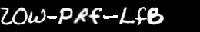

In [4]:
# check one of the train image to see if it is right
Image.open('./data/train/0_ZOW-PRF-LFB.jpg')

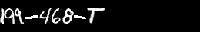

In [5]:
# check one of the test image to see if it is right
Image.open('./data/test/0_199-468-T.jpg')

In [6]:
class MyDataset(Dataset):
    """Create dataset inherited from torch.utils.data.Dataset
    
    Attributes:
        data_dir: train dir or test dir.
        alphabet_map: The map from char to index.
        img_names: File names of all image under the data_dir.
        lables: Labels of all image under the data_dir.
        trans: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
        to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    
    """
    def __init__(self, data_dir):
        """Inits dataset"""
        self.data_dir = data_dir
        self.alphabet_map = alphabet_map
        self.img_names = os.listdir(self.data_dir)
        self.labels = [i.split('_')[1].split('.')[0] for i in self.img_names]
        self.trans = transforms.Compose([
            transforms.ToTensor()
        ])
        
    def __getitem__(self, idx):
        """Get single image by idx
        
        Args:
            idx: index
            
        Returns:
            img: torch.FloatTensor
            label: Actual lable of the image, like "ZOW-PRF-LFB".
        """
        img_path = os.path.join(self.data_dir, self.img_names[idx])
        img = Image.open(img_path)
        img = self.trans(img)
        label = self.labels[idx]
        return img, label
        
    def __len__(self):
        return len(self.labels)

    
class BiLSTM(nn.Module):
    """ Bidirectional LSTM and embedding layer.
    
    Attributes:
        rnn: Bidirectional LSTM
        linear: Embedding layer
    """
    def __init__(self, num_input, num_hiddens, num_output):
        super().__init__()
        self.rnn = nn.LSTM(num_input, num_hiddens, bidirectional=True)
        # the size of input of embedding layer should mutiply by 2, because of the bidirectional.
        self.linear = nn.Linear(num_hiddens * 2, num_output)  
    
    def forward(self, X):
        rnn_out, _ = self.rnn(X)
        T, b, h = rnn_out.size()  # T: time step, b: batch size, h: hidden size
        t_rec = rnn_out.view(T * b, h)
        output = self.linear(t_rec)
        output = output.view(T, b, -1)
        return output


class CRNN(nn.Module):
    """CRNN net, refer to the paper from https://arxiv.org/pdf/1507.05717v1.pdf.
    
    Attributes:
        cnn: nn.Sequential include conv2d/relu/maxpool2d/batchnorm layers,
        input size (1 x 32 X 200), output size ()
        rnn: 
    """
    def __init__(self, num_class):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.rnn = nn.Sequential(
            BiLSTM(512, 256, 256),
            BiLSTM(256, 256, num_class)
        )
        
    def forward(self, X):
        cnn_out = self.cnn(X)  # cnn_out shape: (batch_size x channel x height x width)
        assert cnn_out.shape[2] == 1, "the height of conv must be 1"
        cnn_out = cnn_out.squeeze(2)  # squeeze the dim 2 (height) of cnn_out
        cnn_out = cnn_out.permute(2, 0, 1)  # move the width to the first dim, as the time step of rnn input
        output = self.rnn(cnn_out)  # output shape: (time step x batch_size x num_class)
        output = F.log_softmax(output, dim=2)  # do softmax at the dim of num_class
        return output
        

In [7]:
train_set = MyDataset(data_dir='./data/train/')
batch_size = 64
trainloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)

# Check if the input and output shapes meet expectations
for X, y in trainloader:
    break
print('input shape:', X.shape)
crnn = CRNN(num_class=len(alphabet))
preds = crnn(X)
print('output shape from CRNNnet:', preds.shape)

input shape: torch.Size([64, 1, 32, 200])
output shape from CRNNnet: torch.Size([51, 64, 40])


In [8]:
def get_ctcloss_parameters(text_batch):
    """Convert the real text batch into three parameters required by ctcloss,
    encoded text/predict length/real length
    
    Args:
        text_batch: real text batch, like('E-Z-4', 'EMD-6-04')
        
    Returns:
        encoded_text: encode text by alphabet_map 
        preds_length: (time step x batch_size) => (51 * batch_size)
        actual_length: length of text to index，max(len(text)) * batch_size
    """
    actual_length = []
    result = []
    for item in text_batch:            
        actual_length.append(len(item))
        r = []
        for char in item:
            index = alphabet_map[char]
            r.append(index)
        result.append(r)

    max_len = 0
    for r in result:
        if len(r) > max_len:
            max_len = len(r)

    result_temp = []
    for r in result:
        for i in range(max_len - len(r)):
            r.append(0)
        result_temp.append(r)

    encoded_text = result_temp
    encoded_text = torch.LongTensor(encoded_text)
    preds_length = torch.LongTensor([preds.size(0)] * len(y))
    actual_length = torch.LongTensor(actual_length)
    return encoded_text, preds_length, actual_length

In [12]:
use_gpu = True
num_epoch = 50

if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
crnn.train()
trainer = torch.optim.Adam(crnn.parameters(), lr=0.001)
loss = nn.CTCLoss(zero_infinity=True)
crnn = crnn.to(device)
loss = loss.to(device)
    
for epoch in range(num_epoch):
    for X, y in trainloader:
        X = X.to(device)
        trainer.zero_grad()
        preds = crnn(X) 
        encoded_text, preds_length, actual_length = get_ctcloss_parameters(y)

        encoded_text = encoded_text.to(device)
        preds_length = preds_length.to(device)
        actual_length = actual_length.to(device)
        
        l = loss(preds, encoded_text,preds_length, actual_length) / batch_size
        l.backward()
        trainer.step()
    print('epoch', str(epoch + 1).ljust(10), 'loss:', format(l.item(), '.6f'))

epoch 1          loss: 0.028812
epoch 2          loss: 0.026354
epoch 3          loss: 0.020040
epoch 4          loss: 0.015177
epoch 5          loss: 0.009884
epoch 6          loss: 0.007474
epoch 7          loss: 0.005545
epoch 8          loss: 0.004006
epoch 9          loss: 0.003555
epoch 10         loss: 0.003011
epoch 11         loss: 0.002031
epoch 12         loss: 0.001427
epoch 13         loss: 0.002075
epoch 14         loss: 0.001217
epoch 15         loss: 0.001311
epoch 16         loss: 0.001146
epoch 17         loss: 0.000557
epoch 18         loss: 0.000527
epoch 19         loss: 0.000897
epoch 20         loss: 0.000370
epoch 21         loss: 0.000171
epoch 22         loss: 0.000330
epoch 23         loss: 0.000222
epoch 24         loss: 0.000159
epoch 25         loss: 0.000173
epoch 26         loss: 0.000219
epoch 27         loss: 0.000212
epoch 28         loss: 0.000108
epoch 29         loss: 0.000133
epoch 30         loss: 0.000333
epoch 31         loss: 0.000419
epoch 32

In [15]:
def get_final_pred(text):
    """Remove adjacent duplicate characters

    Args:
        text: Do argmax after crnn net ouput
        
    Returns:
        final_text: Text removed adjacent duplicate characters
    """
    text = list(text)
    for i in range(len(text)):
        for j in range(i + 1, len(text)):
            if text[j] == ' ':
                break
            else:
                if text[j] == text[i]:
                    text[j] = ' '
                else:
                    continue
    final_text = ''.join(text).replace(' ', '')
    return final_text

def predict(net, X, y):
    """Predict batch images, print predict result and ground truth.
    
    Args:
        net: crnn net
        X: batch images
        y: batch actual texts
    """
    preds = net(X)
    _, preds = preds.max(2)
    idx = 0
    print('crnn net output'.ljust(51), '|', 'final predict'.ljust(20), '|', 'ground truth'.ljust(20))
    print('=' * 99)
    for pred in preds.permute(1, 0):
        pred_text = ''.join([alphabet[i.item()] for i in pred])
        print(pred_text, '|', get_final_pred(pred_text).ljust(20), '|', y[idx].ljust(20))
        print('·' * 99)
        idx += 1

In [17]:
test_set = MyDataset(data_dir='./data/test/')

# predict single image with random index
idx = random.randint(0, len(test_set) - 1)
X, y = test_set[idx]
X = X.unsqueeze(0) # add dim as batch
y = [y]
X = X.to(device)
predict(crnn, X, y)

# predict batch using dataloader
testloader = DataLoader(test_set, batch_size=8, shuffle=True, drop_last=True)
X, y = next(iter(testloader))
X = X.to(device)
predict(crnn, X, y)

crnn net output                                     | final predict        | ground truth        
V    --6   --R   E   K                              | V-6-REK              | V-6-REK             
···································································································
crnn net output                                     | final predict        | ground truth        
F   N    W   TT     --F   P  P     --S   W          | FNWT-FPP-SW          | FNWT-FPP-SW         
···································································································
U  I A   --C   S   S   A      --R   O   M   I       | UIA-CSSA-ROMI        | UR-CSSK-ROAI        
···································································································
6   3   --B   4     --U   C   A                     | 63-B4-UCA            | 63-BH-UCA           
···································································································
1 1  3      